In [1]:
import sys
sys.path.append("../..")

In [2]:
import s3fs
import boto3, botocore

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# local:
import s3_config

In [3]:
%%time
headers = [
    # Non-sentiment information about article
    'gkg_id', 'date', 'source', 'source_name', 'doc_id', 
    'themes', 'locations', 'persons', 'orgs', 
    # "Core emotional dimensions" & wc - see 1.5TONE in GKG codebook for details
    'tone',  # pos - neg
    'pos',  # % of words with "positive emotional connotation"
    'neg',  # % of words with "negative emotional connotation"
    'polarity',  # how emotionally charged is the text (as a %)
    'ard',  # activity reference density
    'srd',  # self/group reference density
    'wc',  # word count
    # GCAM entries
    # Lexicoder sentiment dictionary
    'lexicode_neg', 'lexicode_pos',
    # Lexicoder Topic Dictionaries
    'MACROECONOMICS', 'ENERGY', 'FISHERIES', 
    'TRANSPORTATION', 'CRIME', 'SOCIAL_WELFARE',
    'HOUSING', 'FINANCE', 'DEFENCE', 'SSTC',
    'FOREIGN_TRADE', 'CIVIL_RIGHTS', 
    'INTL_AFFAIRS', 'GOVERNMENT_OPS',
    'LAND-WATER-MANAGEMENT', 'CULTURE',
    'PROV_LOCAL', 'INTERGOVERNMENTAL',
    'CONSTITUTIONAL_NATL_UNITY', 'ABORIGINAL',
    'RELIGION', 'HEALTHCARE', 'AGRICULTURE',
    'FORESTRY', 'LABOUR', 'IMMIGRATION',
    'EDUCATION', 'ENVIRONMENT',
    # Central Bank Financial Stability Sentiment
    'finstab_pos', 'finstab_neg', 'finstab_neutral',
    # Loughran & McDonald Financial Sentiment
    'finsent_neg', 'finsent_pos', 'finsent_unc',
    # Opinion observer
    'opin_neg', 'opin_pos',
    # SentiWord
    'sent_pos', 'sent_neg', 'sent_pol'
]

fs = s3fs.core.S3FileSystem(anon=False, profile=s3_config.normal_role)
with fs.open("s3://statsnz-covid-xmiles/merged_gdelt/gdelt-nz-20-21.csv") as f:
    nz = pd.read_csv(f)
nz.columns = headers
nz['date'] = pd.to_datetime(nz['date'], format = "%Y%m%d%H%M%S")

CPU times: user 46.8 s, sys: 5.94 s, total: 52.8 s
Wall time: 2min 8s


In [5]:
na_counts = {c: round(nz[c].isna().sum() / nz.shape[0], 4) for c in nz.columns}
print(na_counts)

{'gkg_id': 0.0, 'date': 0.0, 'source': 0.0, 'source_name': 0.0, 'doc_id': 0.0, 'themes': 0.1387, 'locations': 0.0, 'persons': 0.1271, 'orgs': 0.1488, 'tone': 0.0, 'pos': 0.0, 'neg': 0.0, 'polarity': 0.0, 'ard': 0.0, 'srd': 0.0, 'wc': 0.0, 'lexicode_neg': 0.0062, 'lexicode_pos': 0.0022, 'MACROECONOMICS': 0.6698, 'ENERGY': 0.9022, 'FISHERIES': 0.9681, 'TRANSPORTATION': 0.56, 'CRIME': 0.7464, 'SOCIAL_WELFARE': 0.9528, 'HOUSING': 0.6112, 'FINANCE': 0.5596, 'DEFENCE': 0.8777, 'SSTC': 0.7955, 'FOREIGN_TRADE': 0.8973, 'CIVIL_RIGHTS': 0.7289, 'INTL_AFFAIRS': 0.658, 'GOVERNMENT_OPS': 0.9052, 'LAND-WATER-MANAGEMENT': 0.8318, 'CULTURE': 0.0054, 'PROV_LOCAL': 0.8488, 'INTERGOVERNMENTAL': 0.9997, 'CONSTITUTIONAL_NATL_UNITY': 0.9931, 'ABORIGINAL': 0.9918, 'RELIGION': 0.9113, 'HEALTHCARE': 0.4635, 'AGRICULTURE': 0.9355, 'FORESTRY': 0.9462, 'LABOUR': 0.7854, 'IMMIGRATION': 0.8847, 'EDUCATION': 0.8256, 'ENVIRONMENT': 0.8524, 'finstab_pos': 0.0042, 'finstab_neg': 1.0, 'finstab_neutral': 1.0, 'finsent_ne

Need to convert lexicode (and other sentiments) to percentages, as they are currently counts.

In [6]:
count_headers = [
    # Lexicoder sentiment dictionary
    'lexicode_neg', 'lexicode_pos',
    # Lexicoder Topic Dictionaries
    'MACROECONOMICS', 'ENERGY', 'FISHERIES', 
    'TRANSPORTATION', 'CRIME', 'SOCIAL_WELFARE',
    'HOUSING', 'FINANCE', 'DEFENCE', 'SSTC',
    'FOREIGN_TRADE', 'CIVIL_RIGHTS', 
    'INTL_AFFAIRS', 'GOVERNMENT_OPS',
    'LAND-WATER-MANAGEMENT', 'CULTURE',
    'PROV_LOCAL', 'INTERGOVERNMENTAL',
    'CONSTITUTIONAL_NATL_UNITY', 'ABORIGINAL',
    'RELIGION', 'HEALTHCARE', 'AGRICULTURE',
    'FORESTRY', 'LABOUR', 'IMMIGRATION',
    'EDUCATION', 'ENVIRONMENT',
    # Central Bank Financial Stability Sentiment
    'finstab_pos', 'finstab_neg', 'finstab_neutral',
    # Loughran & McDonald Financial Sentiment
    'finsent_neg', 'finsent_pos', 'finsent_unc',
    # Opinion observer
    'opin_neg', 'opin_pos',
]

pos_headers = [h for h in headers if 'pos' in h]
print("Positive metrics:", pos_headers)
cols_to_summarise = ['date'] + pos_headers

nz_pct = nz.copy()
for col in count_headers:
    nz_pct[col] = nz_pct[col] / nz_pct['wc']

nz_pct_pos = nz_pct[cols_to_summarise].groupby('date').agg(['mean', np.std])
nz_pct_pos_long = nz_pct_pos.reset_index().melt(id_vars='date', var_name=['indicator','summary_metric'])
print("Head of summary df:")
nz_pct_pos.head(10)

Positive metrics: ['pos', 'lexicode_pos', 'finstab_pos', 'finsent_pos', 'opin_pos', 'sent_pos']
Head of summary df:


pos           lexicode_pos           finstab_pos  \
                         mean       std         mean       std        mean   
date                                                                         
2020-01-01 00:00:00  2.885212  1.204608     0.054620  0.032303    0.041448   
2020-01-01 00:15:00  3.172411  0.925562     0.049267  0.016983    0.037393   
2020-01-01 00:30:00  2.604686  0.989962     0.051338  0.021153    0.040166   
2020-01-01 00:45:00  3.014484  1.194287     0.050148  0.024208    0.039534   
2020-01-01 01:00:00  2.743349  1.005236     0.044934  0.011926    0.039228   
2020-01-01 01:15:00  2.871907  0.983061     0.048983  0.011489    0.035447   
2020-01-01 01:30:00  2.799644  1.062238     0.049431  0.013077    0.044812   
2020-01-01 01:45:00  2.347784  1.204377     0.045169  0.018294    0.043875   
2020-01-01 02:00:00  2.857023  1.308119     0.047242  0.016270    0.042126   
2020-01-01 02:15:00  2.288214  1.018100     0.046157  0.012867    0.037657   

                              finsent_pos            opin_pos            \
                          std        mean       std      mean       std   
date                                                                      
2020-01-01 00:00:00  0.021275    0.023195  0.023629  0.052738  0.028875   
2020-01-01 00:15:00  0.015854    0.011183  0.007891  0.047075  0.016249   
2020-01-01 00:30:00  0.019293    0.011140  0.006620  0.046462  0.017913   
2020-01-01 00:45:00  0.018986    0.012287  0.007929  0.046040  0.019818   
2020-01-01 01:00:00  0.014488    0.008855  0.004239  0.041599  0.012234   
2020-01-01 01:15:00  0.013585    0.008370  0.003766  0.042384  0.012542   
2020-01-01 01:30:00  0.018555    0.009530  0.005574  0.042793  0.011852   
2020-01-01 01:45:00  0.021416    0.011813  0.011977  0.040267  0.015782   
2020-01-01 02:00:00  0.019317    0.012475  0.008991  0.045826  0.018627   
2020-01-01 02:15:00  0.014961    0.008949  0.006093  0.038906  0.012568   

                     sent_pos            
                         mean       std  
date                                     
2020-01-01 00:00:00  0.251664  0.020443  
2020-01-01 00:15:00  0.247478  0.023145  
2020-01-01 00:30:00  0.246238  0.019647  
2020-01-01 00:45:00  0.254860  0.023408  
2020-01-01 01:00:00  0.243773  0.014229  
2020-01-01 01:15:00  0.242546  0.016821  
2020-01-01 01:30:00  0.246547  0.017358  
2020-01-01 01:45:00  0.246333  0.024145  
2020-01-01 02:00:00  0.251199  0.023314  
2020-01-01 02:15:00  0.240026  0.022606

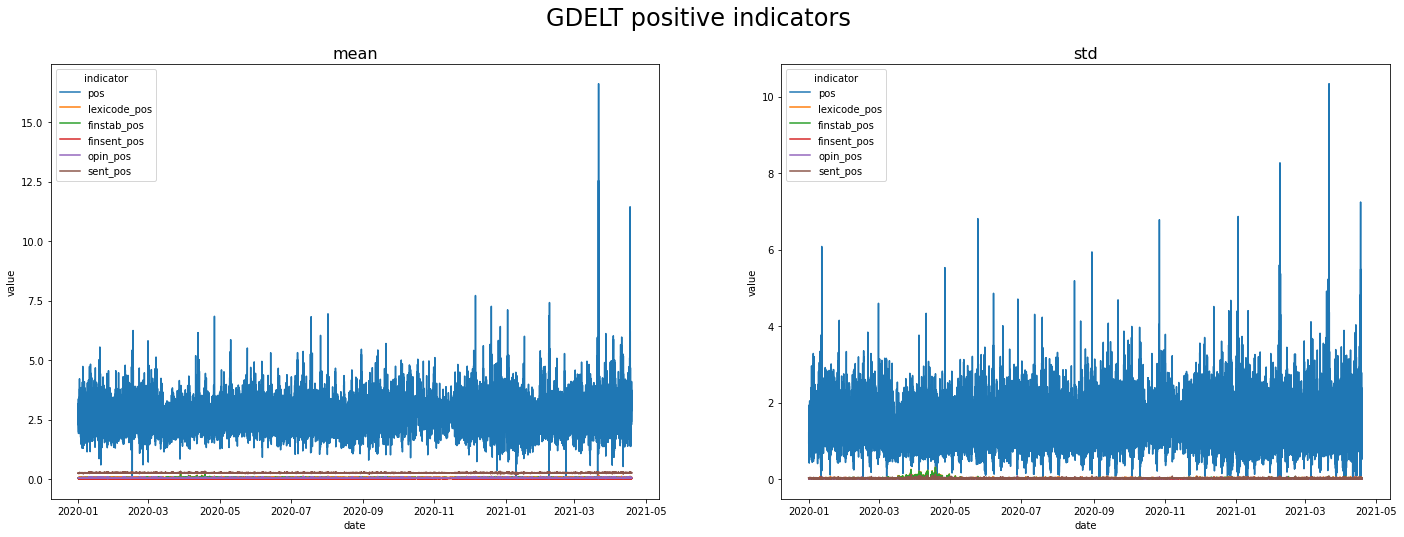

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
fig.suptitle("GDELT positive indicators", fontsize=24)
for i, metric in enumerate(['mean','std']):
    sns.lineplot(
        data=nz_pct_pos_long[nz_pct_pos_long['summary_metric'] == metric],
        x='date', y='value', hue='indicator', ax=ax[i]
    )
    ax[i].set_title(metric, fontsize=16)
plt.show();

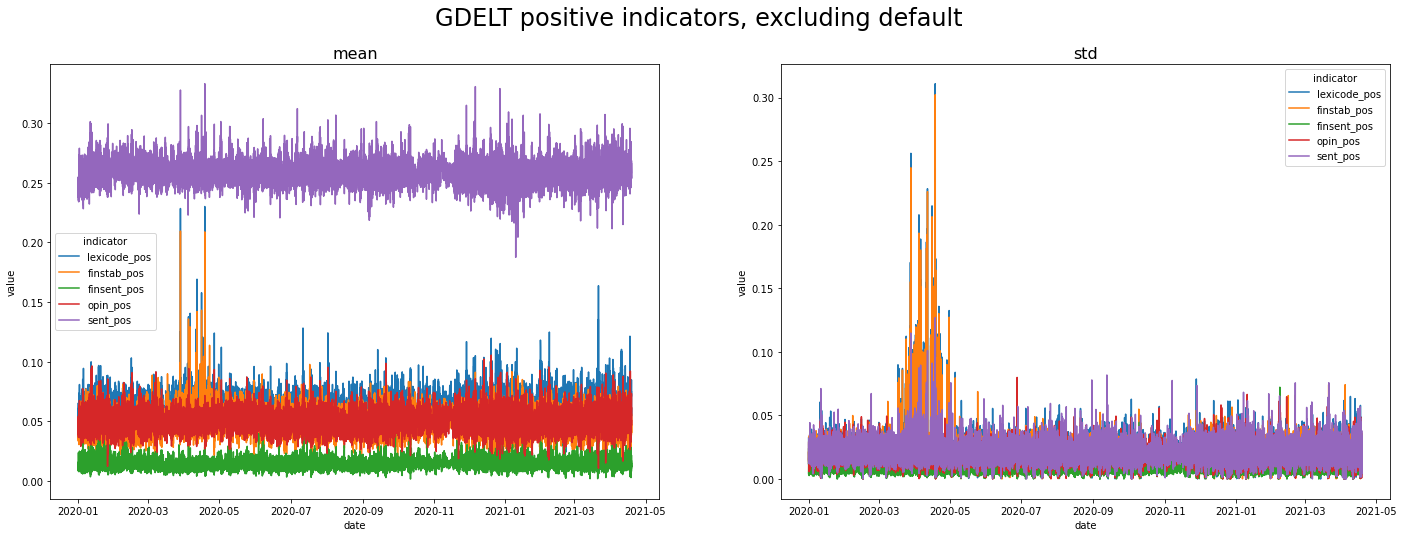

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
fig.suptitle("GDELT positive indicators, excluding default", fontsize=24)
for i, metric in enumerate(['mean','std']):
    sns.lineplot(
        data=nz_pct_pos_long[np.logical_and(nz_pct_pos_long['summary_metric'] == metric, nz_pct_pos_long['indicator'] != 'pos')],
        x='date', y='value', hue='indicator', ax=ax[i]
    )
    ax[i].set_title(metric, fontsize=16)
plt.show();

Even excluding the default positive, there is significant differences between the average of the other indicators. Their standard deviations do seem to be fairly consistent other than the start of COVID. Maybe a normalisation would show them behaving similarly then.

OR maybe it should be comparing the "tone" of each metric. Where the difference of the positive and negative is taken as the sentiment. **Will try this option first.**

In [11]:
# finstab can't be used as the finstab_neg column is all NAs
toneable_dicts = ['lexicode', 'finsent', 'opin']
nz_pct_tones = nz_pct[['date', 'tone']].rename(columns={'tone': 'default'})
for td in toneable_dicts:
    nz_pct_tones = pd.concat([
        nz_pct_tones,
        pd.Series(nz_pct[f"{td}_pos"] - nz_pct[f"{td}_neg"], name=td)
    ], axis = 1)
    
nz_pct_tones_summ = nz_pct_tones.groupby('date').agg(['mean', np.std])
nz_pct_tones_summ_long = nz_pct_tones_summ.reset_index().melt(id_vars='date', var_name=['indicator','summary_metric'])
nz_pct_tones_summ.head(10)

default            lexicode             finsent  \
                         mean       std      mean       std      mean   
date                                                                    
2020-01-01 00:00:00  0.103831  3.277929  0.016336  0.051726  0.004227   
2020-01-01 00:15:00 -0.098947  1.203188  0.005287  0.020811 -0.011805   
2020-01-01 00:30:00 -0.114375  1.578009  0.007753  0.025695 -0.012580   
2020-01-01 00:45:00 -0.333391  2.441089  0.006110  0.033675 -0.014877   
2020-01-01 01:00:00 -0.731098  1.256421  0.000596  0.017807 -0.014738   
2020-01-01 01:15:00 -1.046822  1.945088  0.000266  0.017366 -0.020862   
2020-01-01 01:30:00 -0.953118  2.112102  0.000204  0.019739 -0.020463   
2020-01-01 01:45:00 -0.990207  2.565735 -0.005685  0.027982 -0.018954   
2020-01-01 02:00:00 -0.414936  2.166284  0.000961  0.022075 -0.014012   
2020-01-01 02:15:00 -1.680532  2.250566 -0.006765  0.021263 -0.025051   

                                   opin            
                          std      mean       std  
date                                               
2020-01-01 00:00:00  0.032443  0.013192  0.043903  
2020-01-01 00:15:00  0.012420 -0.000532  0.030609  
2020-01-01 00:30:00  0.012692  0.001861  0.026777  
2020-01-01 00:45:00  0.017544 -0.000668  0.028027  
2020-01-01 01:00:00  0.009182 -0.007964  0.022170  
2020-01-01 01:15:00  0.014243 -0.006490  0.024421  
2020-01-01 01:30:00  0.016135 -0.009843  0.023573  
2020-01-01 01:45:00  0.024792 -0.016189  0.029959  
2020-01-01 02:00:00  0.016700 -0.004363  0.030260  
2020-01-01 02:15:00  0.019033 -0.015015  0.021884

In [20]:
nz_pct_tones_summ_long

,date,indicator,summary_metric,value
0,2020-01-01 00:00:00,default,mean,0.103831
1,2020-01-01 00:15:00,default,mean,-0.098947
2,2020-01-01 00:30:00,default,mean,-0.114375
3,2020-01-01 00:45:00,default,mean,-0.333391
4,2020-01-01 01:00:00,default,mean,-0.731098
...,...,...,...,...
343099,2021-04-18 22:15:00,opin,std,0.026648
343100,2021-04-18 22:30:00,opin,std,0.022540
343101,2021-04-18 22:45:00,opin,std,0.018465
343102,2021-04-18 23:00:00,opin,std,0.020861


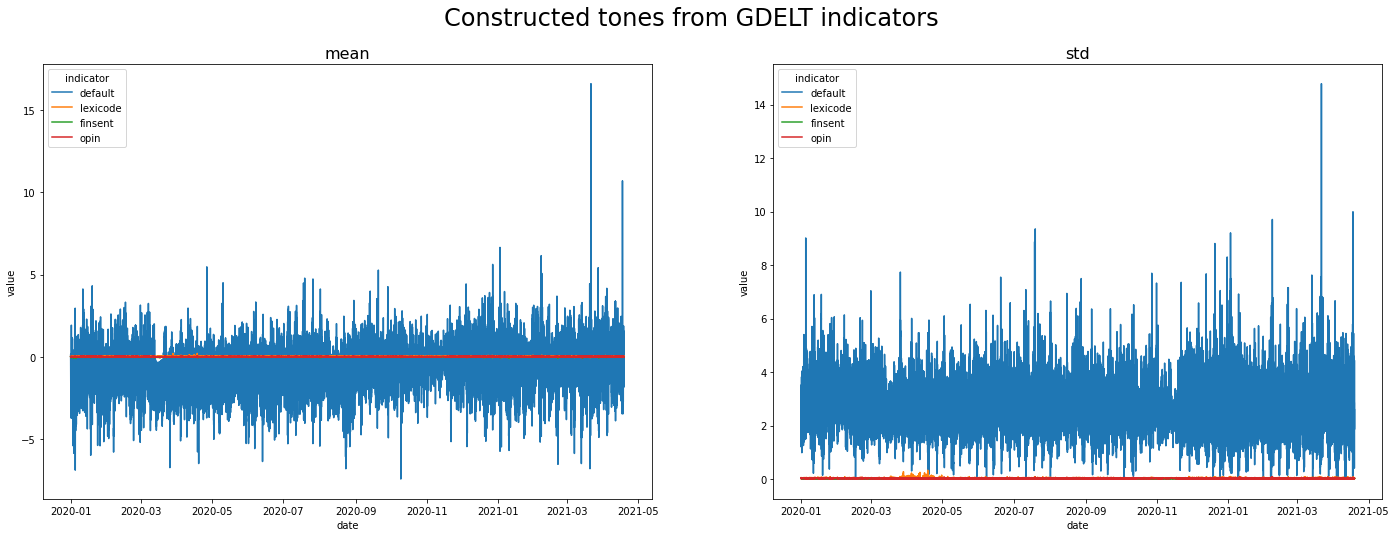

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
fig.suptitle("Constructed tones from GDELT indicators", fontsize=24)
for i, metric in enumerate(['mean','std']):
    sns.lineplot(
        data=nz_pct_tones_summ_long[nz_pct_tones_summ_long['summary_metric'] == metric],
        x='date', y='value', hue='indicator', ax=ax[i]
    )
    ax[i].set_title(metric, fontsize=16)
plt.show();

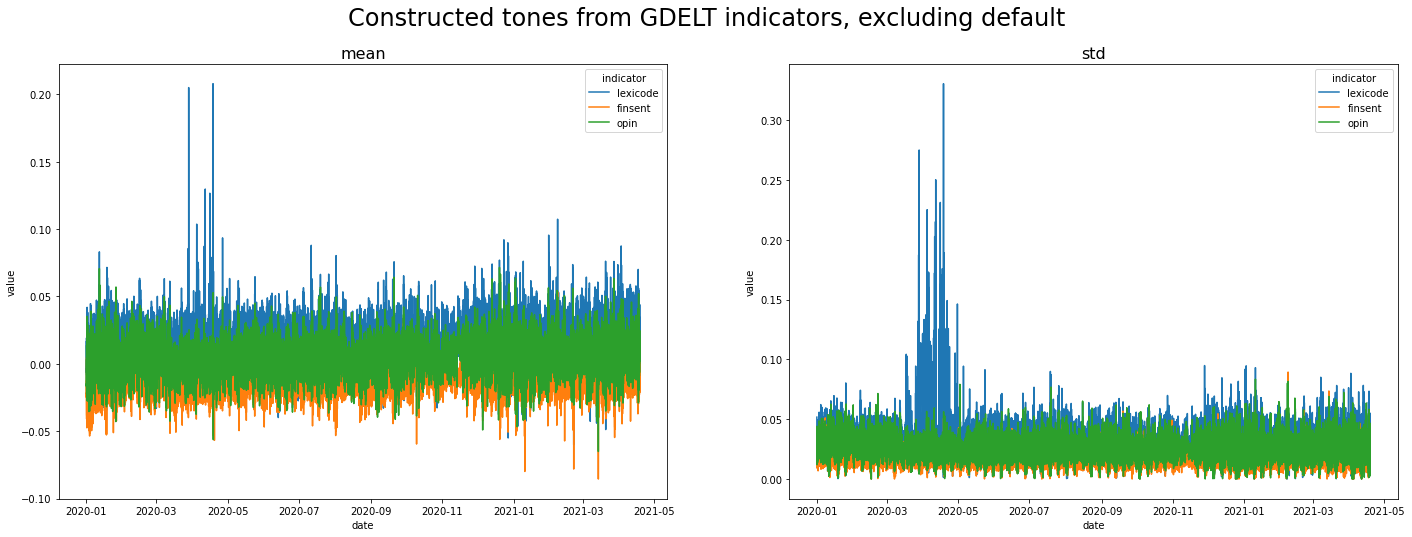

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
fig.suptitle("Constructed tones from GDELT indicators, excluding default", fontsize=24)
for i, metric in enumerate(['mean','std']):
    sns.lineplot(
        data=nz_pct_tones_summ_long[np.logical_and(nz_pct_tones_summ_long['summary_metric'] == metric, nz_pct_tones_summ_long['indicator'] != 'default')],
        x='date', y='value', hue='indicator', ax=ax[i]
    )
    ax[i].set_title(metric, fontsize=16)
plt.show();

## Check number of articles over time

For other related graphs, see `Gdelt/eda_XM/country_comparison.ipnyb`.

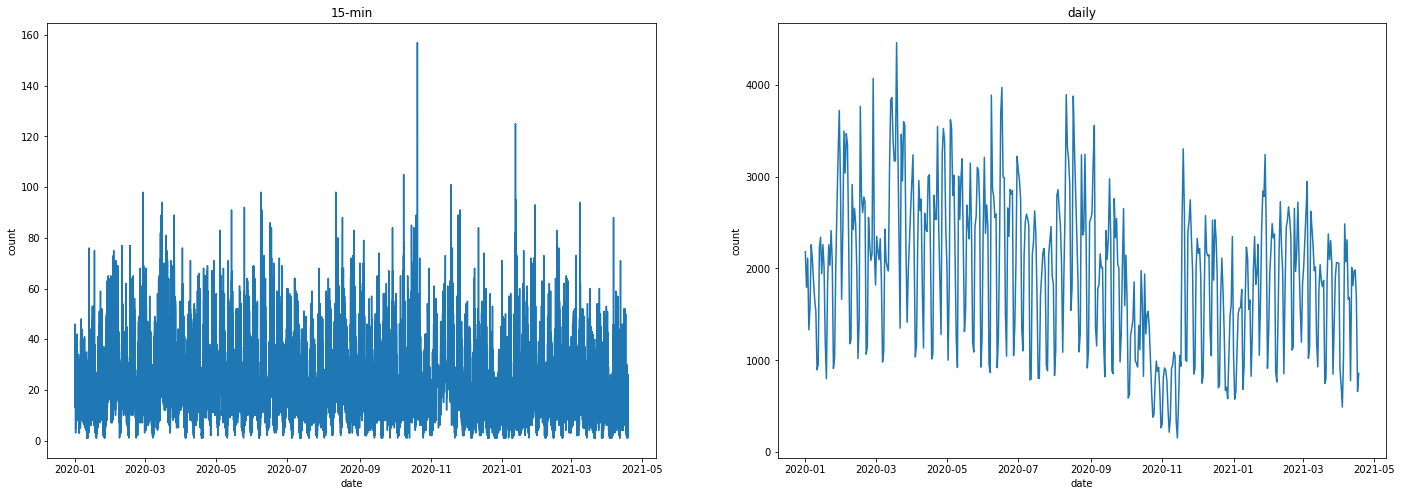

In [9]:
num_articles_15min = nz.groupby('date').count()['gkg_id'].reset_index().rename(columns={'gkg_id': 'count'})
num_articles_d = nz.resample('D', on='date').count()['gkg_id'].reset_index().rename(columns={'gkg_id': 'count'})

fig, ax = plt.subplots(1, 2, figsize = (24, 8))
sns.lineplot(data=num_articles_15min, x='date', y='count', ax=ax[0])
ax[0].set(title="15-min")
sns.lineplot(data=num_articles_d, x='date', y='count', ax=ax[1])
ax[1].set(title="daily")
plt.show();

## Standardise tones

Using:
```
x_standardised = (x - mean) / std_dev
```

In [12]:
standardised_indicators = pd.concat((
    (nz_pct_tones_summ[indicator, 'mean'] - nz_pct_tones_summ[indicator, 'mean'].mean()) / 
    nz_pct_tones_summ[indicator, 'mean'].std()
    for indicator in ['default','lexicode','finsent','opin']
), axis=1).droplevel(1, axis=1).fillna(0)
# ACF/PACT can't be calculated with NAs

standardised_indicators

,default,lexicode,finsent,opin
date,,,,
2020-01-01 00:00:00,0.706486,0.071929,2.287628,0.829318
2020-01-01 00:15:00,0.534269,-0.778028,0.207414,-0.461929
2020-01-01 00:30:00,0.521165,-0.588344,0.106879,-0.236760
2020-01-01 00:45:00,0.335157,-0.714671,-0.191182,-0.474676
2020-01-01 01:00:00,-0.002612,-1.138823,-0.173171,-1.161129
...,...,...,...,...
2021-04-18 22:15:00,1.641001,1.765715,2.100915,1.920205
2021-04-18 22:30:00,-0.061756,0.286470,-0.885174,0.102452
2021-04-18 22:45:00,0.098112,0.709768,-0.394868,0.175722


In [24]:
print(standardised_indicators)

                      default  lexicode   finsent      opin
date                                                       
2020-01-01 00:00:00  0.706486  0.071929  2.287628  0.829318
2020-01-01 00:15:00  0.534269 -0.778028  0.207414 -0.461929
2020-01-01 00:30:00  0.521165 -0.588344  0.106879 -0.236760
2020-01-01 00:45:00  0.335157 -0.714671 -0.191182 -0.474676
2020-01-01 01:00:00 -0.002612 -1.138823 -0.173171 -1.161129
...                       ...       ...       ...       ...
2021-04-18 22:15:00  1.641001  1.765715  2.100915  1.920205
2021-04-18 22:30:00 -0.061756  0.286470 -0.885174  0.102452
2021-04-18 22:45:00  0.098112  0.709768 -0.394868  0.175722
2021-04-18 23:00:00  1.039789  0.592032  0.683440  0.519633
2021-04-18 23:15:00  0.393753  0.585082  0.573607  0.730697

[42888 rows x 4 columns]


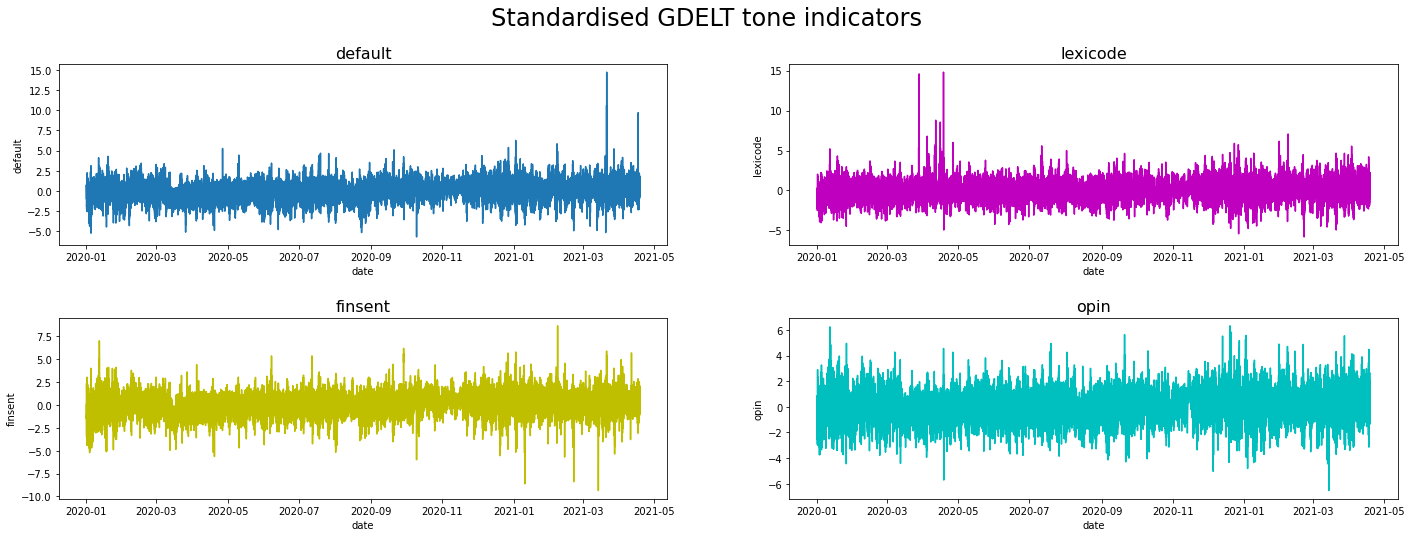

In [59]:
fig, ax = plt.subplots(2, 2, figsize = (24, 8))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("Standardised GDELT tone indicators", fontsize=24)
sns.lineplot(data=standardised_indicators,x='date', y='default', ax=ax[0][0])
ax[0][0].set_title('default', fontsize=16)
sns.lineplot(data=standardised_indicators,x='date', y='lexicode', color='m', ax=ax[0][1])
ax[0][1].set_title('lexicode', fontsize=16)
sns.lineplot(data=standardised_indicators,x='date', y='finsent', color='y', ax=ax[1][0])
ax[1][0].set_title('finsent', fontsize=16)
sns.lineplot(data=standardised_indicators,x='date', y='opin', color='c', ax=ax[1][1])
ax[1][1].set_title('opin', fontsize=16)
plt.show();

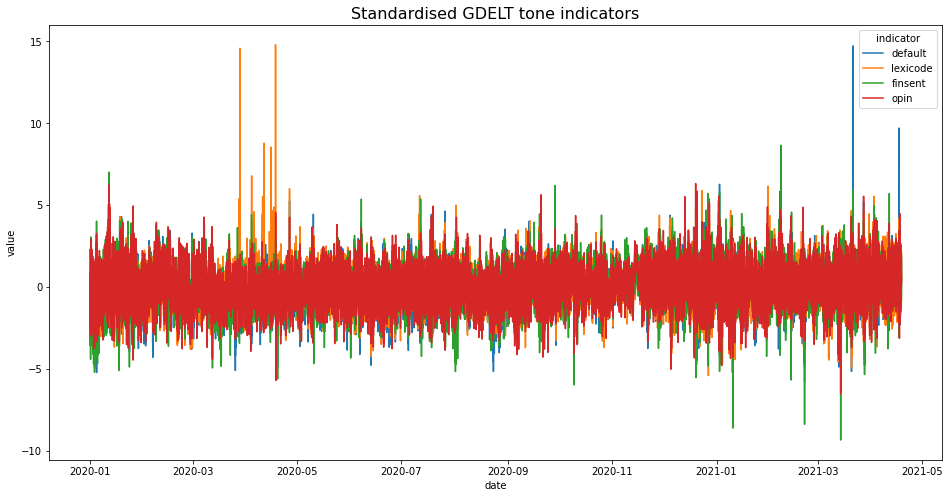

In [13]:
fig, ax = plt.subplots(figsize = (16, 8))
sns.lineplot(
    data=standardised_indicators.reset_index().melt(id_vars='date', var_name='indicator'),
    x='date', y='value', hue='indicator', ax=ax
)
ax.set_title("Standardised GDELT tone indicators", fontsize=16)
plt.show();

## Determine if there is a statistically significant difference

- Fitting common ARIMA (or other) model and then use F-test to test the hypothesis of a common set of parameters ([suggested here](https://stats.stackexchange.com/questions/19103/how-to-statistically-compare-two-time-series)). I don't understand the point about globally vs separately fitting, despite [this link](https://stats.stackexchange.com/questions/395027/comparing-two-time-series-statistically) trying to clarify that exact point.
- Fixed-effects ANOVA ([suggested here](https://stats.stackexchange.com/questions/12902/comparison-of-time-series-sets)). From my understanding, would fit linear regression and test the coefficients
- Granger causality test - used to test whether one series can be used to forecast another, thus implying some level of causal relationship

### ARIMA approach
Fit the same ARIMA(p,d,q) model to all standardised indicators and use some test statistic to assess whether the derived coefficients are statistically significant difference.

In [14]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
standardised_indicators.isna().apply(sum)

default     0
lexicode    0
finsent     0
opin        0
dtype: int64

In [16]:
acf(standardised_indicators['default'], nlags=40, fft=True)

array([1.        , 0.48273465, 0.46447301, 0.44587043, 0.43388663,
       0.42612149, 0.41326538, 0.38973369, 0.38008573, 0.36959292,
       0.35615034, 0.35236961, 0.33801429, 0.32163108, 0.31417336,
       0.30099592, 0.29934424, 0.28506678, 0.28122541, 0.2724563 ,
       0.26275847, 0.25493162, 0.25152945, 0.24313954, 0.23919256,
       0.22881788, 0.22516675, 0.22537686, 0.21645951, 0.21022265,
       0.20499566, 0.19957883, 0.19867924, 0.19591773, 0.19168221,
       0.18795522, 0.18170709, 0.1805574 , 0.17944181, 0.17772861,
       0.17583666])

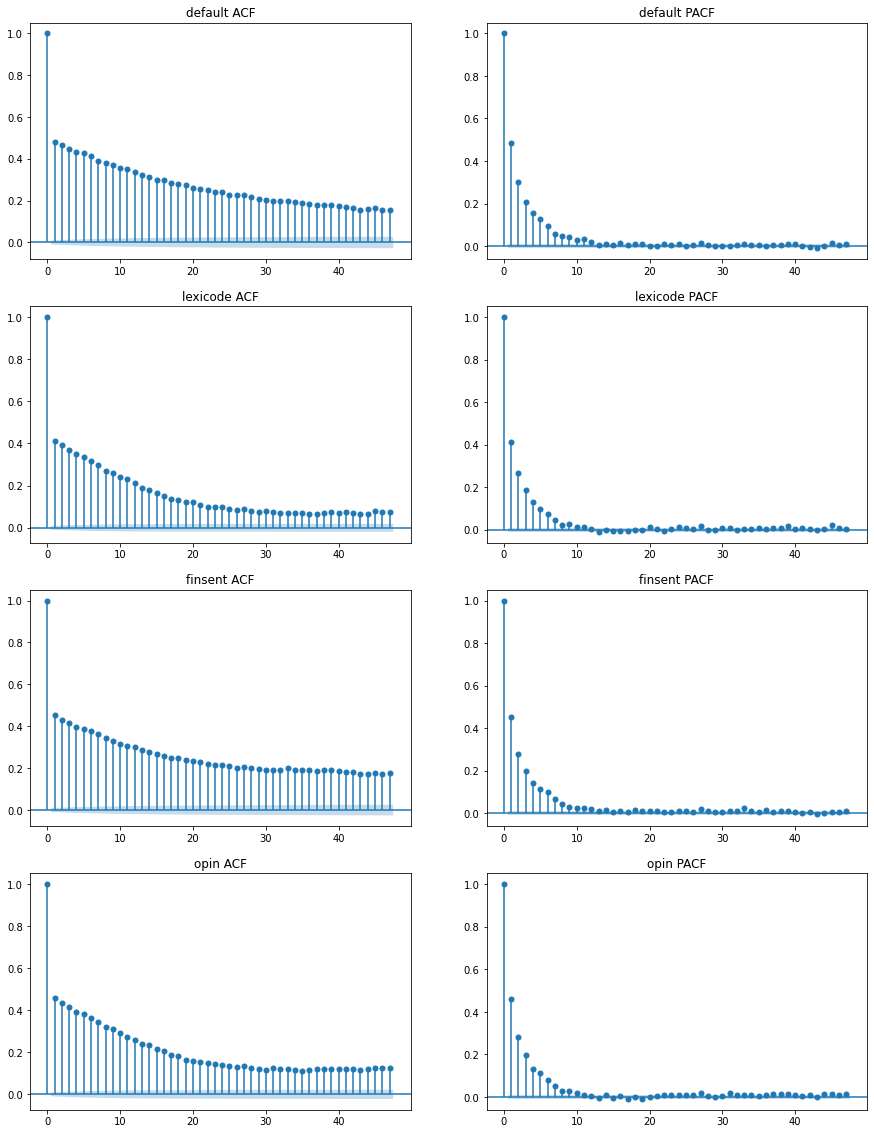

In [17]:
fig, ax = plt.subplots(len(standardised_indicators.columns), 2, 
                       figsize=(15, len(standardised_indicators.columns) * 5))
for i, indicator in enumerate(standardised_indicators.columns):
    plot_acf(standardised_indicators[indicator], 
#            missing='conservative',
             title=f"{indicator} ACF",
             ax=ax[i, 0]
             )
    plot_pacf(standardised_indicators[indicator], 
#             missing='conservative',
              title=f"{indicator} PACF",
              ax=ax[i, 1]
              )
plt.show();

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

Try to achieve stationarity with default tone.

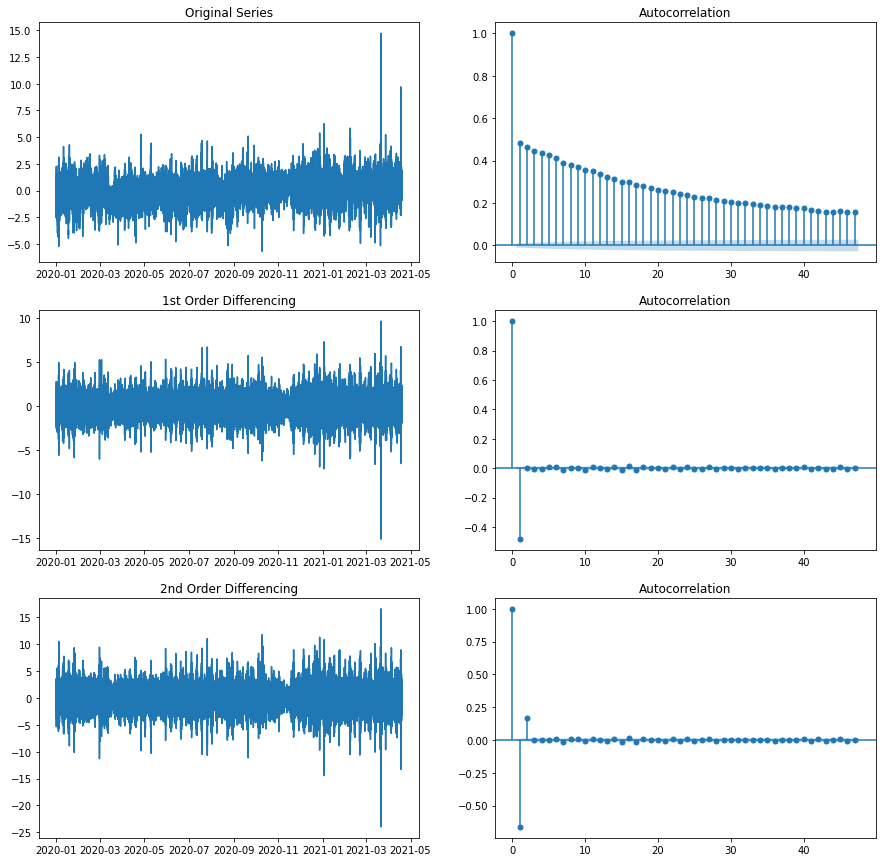

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
# Original Series
axes[0, 0].plot(standardised_indicators['default']) 
axes[0, 0].set_title('Original Series')
plot_acf(standardised_indicators['default'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(standardised_indicators['default'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(standardised_indicators['default'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(standardised_indicators['default'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(standardised_indicators['default'].diff().diff().dropna(), ax=axes[2, 1]);

So, 1st order differencing is sufficient to achieve stationarity.

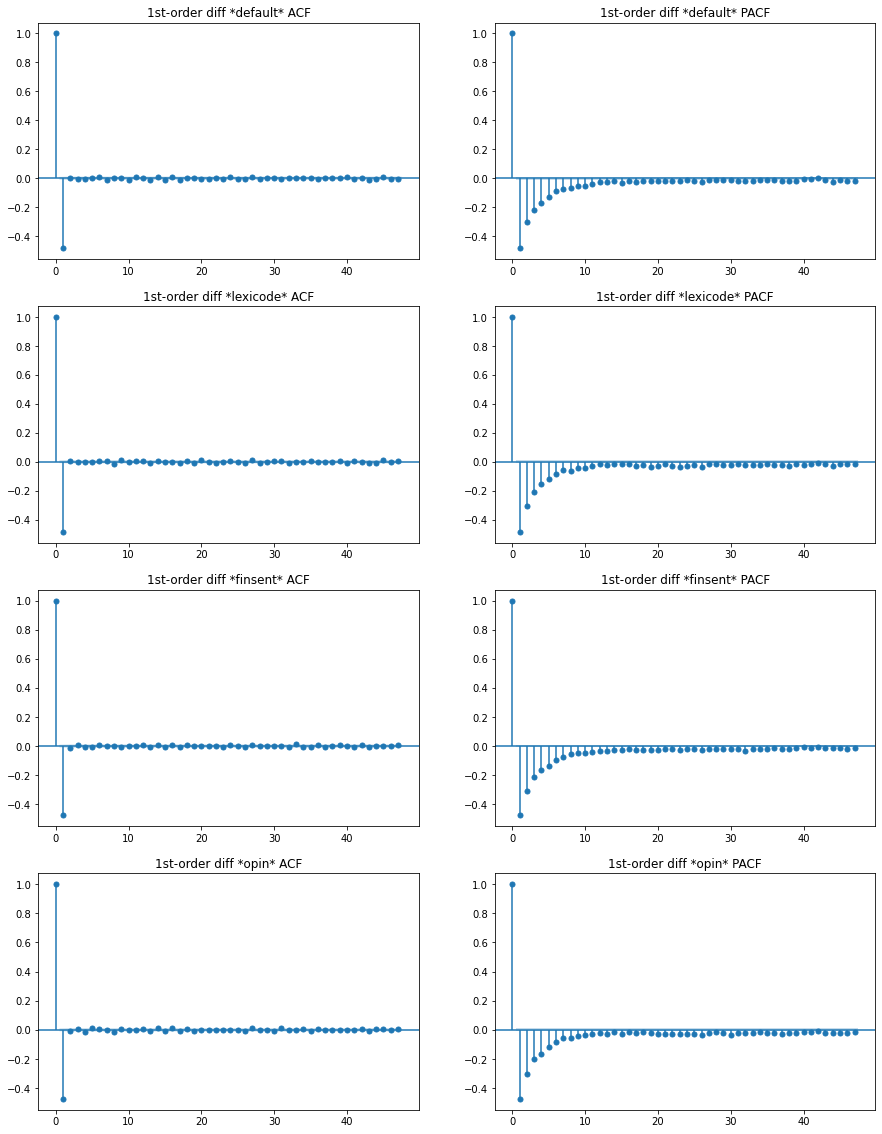

In [19]:
fig, ax = plt.subplots(len(standardised_indicators.columns), 2, 
                       figsize=(15, len(standardised_indicators.columns) * 5))
for i, indicator in enumerate(standardised_indicators.columns):
    plot_acf(standardised_indicators[indicator].diff().dropna(),
             title=f"1st-order diff *{indicator}* ACF",
             ax=ax[i, 0]
             )
    plot_pacf(standardised_indicators[indicator].diff().dropna(),
              title=f"1st-order diff *{indicator}* PACF",
              ax=ax[i, 1]
              )
plt.show();

Just one AutoRegressive/AR term then?

In [20]:
# ARIMA(p=1,d=1,q=0)
default_model = ARIMA(standardised_indicators['default'], order=(1,1,0))
default_model_fit = default_model.fit()
default_model_fit.summary()

/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                default   No. Observations:                42888
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -55902.690
Date:                Thu, 08 Jul 2021   AIC                         111809.380
Time:                        20:12:33   BIC                         111826.713
Sample:                             0   HQIC                        111814.848
                              - 42888                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4824      0.003   -180.263      0.000      -0.488      -0.477
sigma2         0.7938      0.003    250.321      0.000       0.788       0.800
===================================================================================
Ljung-Box (L1) (Q):                 914.86   Jarque-Bera (JB):             26432.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Compare to simple alternative - ARIMA(p=0,d=1,q=1)
default_model = ARIMA(standardised_indicators['default'], order=(0,1,1))
default_model_fit = default_model.fit()
default_model_fit.summary()

/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                default   No. Observations:                42888
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -51206.101
Date:                Thu, 08 Jul 2021   AIC                         102416.203
Time:                        20:12:35   BIC                         102433.535
Sample:                             0   HQIC                        102421.671
                              - 42888                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8079      0.002   -349.872      0.000      -0.812      -0.803
sigma2         0.6377      0.002    270.060      0.000       0.633       0.642
===================================================================================
Ljung-Box (L1) (Q):                  15.14   Jarque-Bera (JB):             41570.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ljung-Box value indicates whether "the residuals from the [fitted] ARIMA model have no autocorrelation". The Ljung-Box p-values indicate that there is still lagged dependencies in the residuals of the ARIMA model SO the model is not correctly specified.

H0: The data is independently distributed \
Ha: The data is not independently distributed; it exhibits serial correlation

Thus a good model would not have a low p-value since then it is *possible* that the residuals of the fit are independent, which would mean that the model effectively explains the variations in the data.

In [22]:
default_model = ARIMA(standardised_indicators['default'], order=(1,1,1))
default_model_fit = default_model.fit()
default_model_fit.summary()

/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                default   No. Observations:                42888
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -51193.356
Date:                Thu, 08 Jul 2021   AIC                         102392.713
Time:                        20:12:37   BIC                         102418.712
Sample:                             0   HQIC                        102400.915
                              - 42888                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0316      0.004      7.057      0.000       0.023       0.040
ma.L1         -0.8207      0.003   -282.794      0.000      -0.826      -0.815
sigma2         0.6373      0.002    265.062      0.000       0.633       0.642
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             40560.31
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(1,1,1) seems like a far better fit according to Ljung-Box and since all the coefficients are definitely statistically significant.

In [23]:
standardised_indicators.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:15:00',
               '2020-01-01 00:30:00', '2020-01-01 00:45:00',
               '2020-01-01 01:00:00', '2020-01-01 01:15:00',
               '2020-01-01 01:30:00', '2020-01-01 01:45:00',
               '2020-01-01 02:00:00', '2020-01-01 02:15:00',
               ...
               '2021-04-18 21:00:00', '2021-04-18 21:15:00',
               '2021-04-18 21:30:00', '2021-04-18 21:45:00',
               '2021-04-18 22:00:00', '2021-04-18 22:15:00',
               '2021-04-18 22:30:00', '2021-04-18 22:45:00',
               '2021-04-18 23:00:00', '2021-04-18 23:15:00'],
              dtype='datetime64[ns]', name='date', length=42888, freq=None)

In [24]:
# Missing some datetimes - reason for the warning
len(pd.date_range(pd.to_datetime("2020-01-01 00:00:00"),pd.to_datetime("2021-04-18 23:15:00"), freq='15min')) - len(standardised_indicators.index)

2614

In [25]:
print(
    "Percent of datetimes missing:\n" + \
    f"{100 * (len(pd.date_range(pd.to_datetime('2020-01-01 00:00:00'),pd.to_datetime('2021-04-18 23:15:00'), freq='15min')) - len(standardised_indicators.index)) / len(standardised_indicators.index):.4f} %"
)

Percent of datetimes missing:
6.0949 %


**Fit all models now**

In [26]:
model_fits = {}
for c in standardised_indicators.columns:
    model_fits[c] = ARIMA(standardised_indicators[c], order=(1,1,1)).fit()

/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/xmiles/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provide

In [127]:
print(dir(model_fits['default']))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_cache', '_cov_approx_centered', '_cov_approx_complex_step', '_cov_params_approx', '_cov_params_oim', '_cov_params_opg', '_cov_params_robust_approx', '_cov_params_robust_oim', '_data_attr', '_data_attr_model', '_data_in_cache', '_fixed_params', '_fixed_params_index', '_free_params_index', '_get_robustcov_results', '_has_fixed_params', '_init_kwds', '_news_previous_data', '_news_previous_results', '_news_updated_data', '_news_updated_results', '_params_ar', '_params_ma', '_params_variance', '_rank', '_states', '_use_t', 'aic', 'aicc', 'append', 'apply', 'arfreq', 'arparams', 'arroots', 'bic', 'bse', 'conf_int', 'cov_kwds', 'cov_params', 

In [128]:
model_fits['default'].params

ar.L1     0.031628
ma.L1    -0.820724
sigma2    0.637274
dtype: float64

In [27]:
for k, v in model_fits.items():
    print(k)
    print("AR coeff:", v.polynomial_ar)
    print("MA coeff:", v.polynomial_ma)
    print()

default
AR coeff: [ 1.         -0.03162834]
MA coeff: [ 1.         -0.82072427]

lexicode
AR coeff: [ 1.         -0.02108375]
MA coeff: [ 1.        -0.7971567]

finsent
AR coeff: [ 1.         -0.04857217]
MA coeff: [ 1.         -0.83428454]

opin
AR coeff: [ 1.         -0.03374913]
MA coeff: [ 1.         -0.79484242]



Pretty similar. Now to test whether there is statistically significant differences. HOW???

In [121]:
# dir(ARIMAResults.f_test obj) : 'conf_int','df_denom','df_num','dist','dist_args','distribution','effect','fvalue','pvalue','statistic','summary','summary_frame'

# tests that each coefficient is jointly statistically significantly different from zero.
print(model_fits['default'].f_test(
    np.identity(len(model_fits['default'].params))[1:, :]
))

<F test: F=array([[80987.19074515]]), p=nan, df_denom=inf, df_num=2>


In [126]:
print(
    dir(model_fits['default']#.f_test(
#         np.identity(len(model_fits['default'].params))[1:, :]
    )
)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_cache', '_cov_approx_centered', '_cov_approx_complex_step', '_cov_params_approx', '_cov_params_oim', '_cov_params_opg', '_cov_params_robust_approx', '_cov_params_robust_oim', '_data_attr', '_data_attr_model', '_data_in_cache', '_fixed_params', '_fixed_params_index', '_free_params_index', '_get_robustcov_results', '_has_fixed_params', '_init_kwds', '_news_previous_data', '_news_previous_results', '_news_updated_data', '_news_updated_results', '_params_ar', '_params_ma', '_params_variance', '_rank', '_states', '_use_t', 'aic', 'aicc', 'append', 'apply', 'arfreq', 'arparams', 'arroots', 'bic', 'bse', 'conf_int', 'cov_kwds', 'cov_params', 

In [122]:
ARIMA(pd.get_dummies(standardised_indicators.reset_index().melt(id_vars='date', var_name="indicator")), order=c(1,1,1))

TypeError: 'str' object is not callable

### Granger causality test

This tests whether *X forecasts Y*.

In [58]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(standardised_indicators[['default','lexicode']], maxlag=2);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=88.0535 , p=0.0000  , df_denom=42884, df_num=1
ssr based chi2 test:   chi2=88.0596 , p=0.0000  , df=1
likelihood ratio test: chi2=87.9694 , p=0.0000  , df=1
parameter F test:         F=88.0535 , p=0.0000  , df_denom=42884, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=43.0030 , p=0.0000  , df_denom=42881, df_num=2
ssr based chi2 test:   chi2=86.0159 , p=0.0000  , df=2
likelihood ratio test: chi2=85.9298 , p=0.0000  , df=2
parameter F test:         F=43.0030 , p=0.0000  , df_denom=42881, df_num=2


In [74]:
print(grangercausalitytests(standardised_indicators[['default','lexicode']], maxlag=1, verbose=False)[1][0])

{'ssr_ftest': (88.0534820410202, 6.671800519861247e-21, 42884.0, 1), 'ssr_chi2test': (88.05964192456938, 6.351031202288349e-21, 1), 'lrtest': (87.96935929806205, 6.647629661437298e-21, 1), 'params_ftest': (88.05348204101485, 6.671800519861247e-21, 42884.0, 1.0)}


In [153]:
names = standardised_indicators.columns
max_nlags = 2
print("Granger Causality Test")

for nlags in range(1, max_nlags + 1):
    pvals = 99 * np.ones((len(names), len(names)))
    for i, n_i in enumerate(names):
        for j, n_j in enumerate(names):
            if i == j:
                pvals[i, j] = np.nan
            else:
                pvals[i, j] = grangercausalitytests(standardised_indicators[[n_i, n_j]], maxlag=nlags, verbose=False)[nlags][0]['ssr_ftest'][1]

    pvals = pd.DataFrame(pvals, 
                         columns=pd.MultiIndex.from_product([['predictee'], names]), 
                         index=pd.MultiIndex.from_product([['predictor'], names]))
    print(f"\n" + 60*"-" + f"\npalues for Lag {nlags}:")
    print(pvals.round(4).fillna(""))

Granger Causality Test

------------------------------------------------------------
palues for Lag 1:
                   predictee                         
                     default lexicode finsent    opin
predictor default                 0.0     0.0  0.6893
          lexicode       0.0           0.0105     0.0
          finsent        0.0   0.0745          0.0001
          opin           0.0   0.5455  0.0007        

------------------------------------------------------------
palues for Lag 2:
                   predictee                         
                     default lexicode finsent    opin
predictor default                 0.0     0.0  0.8277
          lexicode       0.0              0.0     0.0
          finsent        0.0   0.0875          0.0026
          opin           0.0   0.0419     0.0        


Looks like they forecast each other pretty well.